# Lab 3
### Kirill Zakharov

### Задание:
1. Преобразование Фурье. (Изобразить диаграмму мощности гармоник, увидеть, чем периодический ряд отличается от хаотическогорю Use numpy.fft.fft)
2. Сингулярное спектральное разложение (Изобразить наиболее характерные компоненты с помощью pymssa).
3. Прогноз на несколько шагов с помощью SSA. (Будет охота поэкспериментировать с Фурье — тоже можно)
4. Изображение автокорреляционных функций для обоих рядов.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline
from Libraries.features import CHurst, CEmbDim, KSEntr, HurstTraj, DimEmb
from scipy.stats import entropy
import scipy

from sklearn.manifold import TSNE
import plotly.express as px
import nolds
from nolitsa import dimension, delay
from giottotda.gtda.time_series import embedding, TakensEmbedding
from sklearn.cluster import AgglomerativeClustering
from pymssa import MSSA

plt.style.use('ggplot')

/Users/kirillzakharov/Desktop/Master Degree ITMO/Mathematical tools/pymssa/mssa.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### Рассмотрим два временных ряда - дневные котировки цены акции и уровень энергии на электростанстации

In [2]:
data_stock = pd.read_csv('zeus.us.txt')['Close'].values
data_energy = pd.read_csv('energy_data.csv').iloc[:,0].values

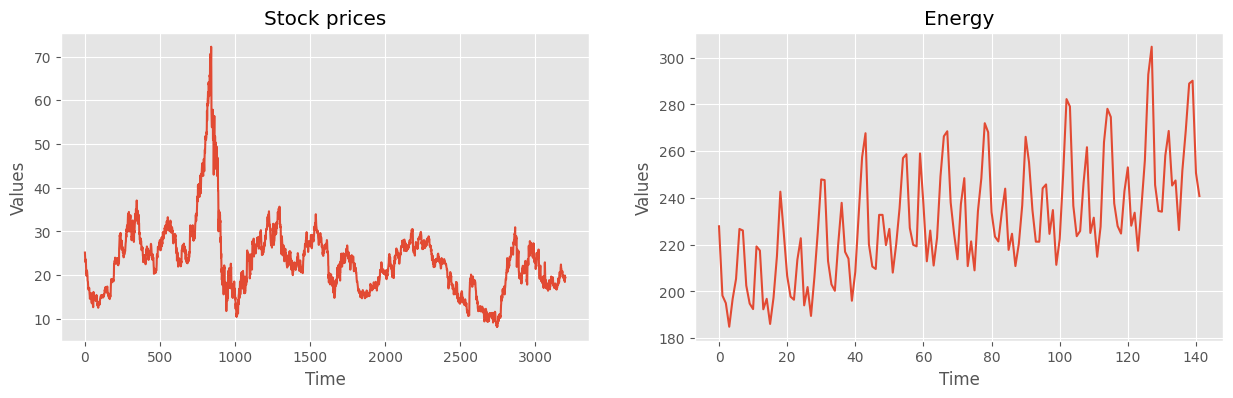

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(data_stock)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')
axs[0].set_title('Stock prices')

axs[1].plot(data_energy)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Values')
axs[1].set_title('Energy')

plt.subplots_adjust(wspace=0.2)
plt.show()

# 1.

Напишем функцию вычисления частот и магнитуды.

In [4]:
def fft(data):
    freq = np.fft.fftfreq(len(data), d=0.01)
    mag =  2 * np.abs(np.fft.fft(data)) / len(data)
    
    return freq, mag

Поскольку спектр симметричен, то отберем только половину.

In [5]:
neg_idx_stock = np.argmax(fft(data_stock)[0] < 0)
neg_idx_energy = np.argmax(fft(data_energy)[0] < 0)

Для акции нет доминирующих частот, так как ряд сильно хаотичен. Для ряда энергии можно заметить всплески в районе частот 12, 24, 58.

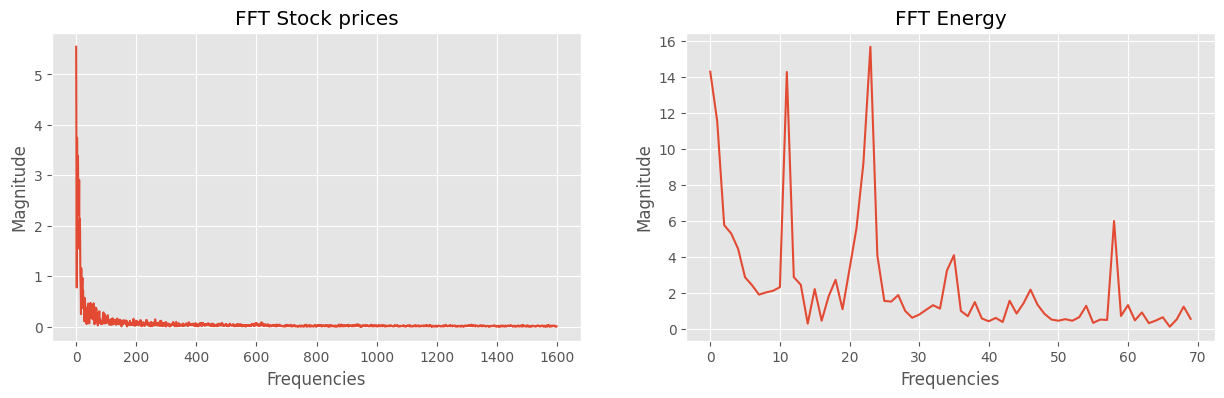

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(fft(data_stock)[1][1:neg_idx_stock])
axs[0].set_xlabel('Frequencies')
axs[0].set_ylabel('Magnitude')
axs[0].set_title('FFT Stock prices')

axs[1].plot(fft(data_energy)[1][1:neg_idx_energy])
axs[1].set_xlabel('Frequencies')
axs[1].set_ylabel('Magnitude')
axs[1].set_title('FFT Energy')

plt.subplots_adjust(wspace=0.2)
plt.show()

Сделаем модельный пример с синусом, возьмем сумму двух синусоид, первая с частотой 4 и амплитудой 2, а вторая с частотой 27 и амплитудой 3.

In [7]:
data_sin = 2 * np.sin(2 * np.pi * 4 * np.linspace(0, 1, 100)) + 3 * np.sin(2 * np.pi * 27 * np.linspace(0, 1, 100))
neg_idx_sin = np.argmax(fft(data_sin)[0] < 0)

На рисунке справа изображено частотное представление сигнала. Наблюдаются два всплеска соответствуюшие двум частотам синусоиды и их величина (магнитуда) совпадает с заданной амплитудой сигнала.

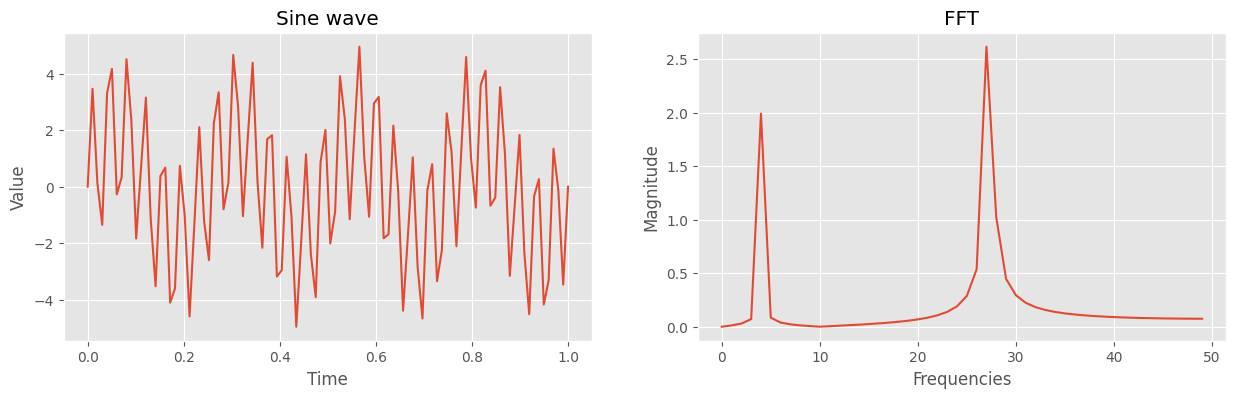

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(np.linspace(0, 1, 100), data_sin)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')
axs[0].set_title('Sine wave')

axs[1].plot(fft(data_sin)[1][0:neg_idx_sin])
axs[1].set_xlabel('Frequencies')
axs[1].set_ylabel('Magnitude')
axs[1].set_title('FFT')

plt.subplots_adjust(wspace=0.2)
plt.show()

# 2.

Сделаем сингулряное спектральное разложение для двух временных рядов с шириной окна 100 для акции и 10 для энергии. Ширина окна влияет на размерность матрицы траекторий, а значит и на количество ее собственных векторов. На практике число сингулрных чисел совпадает с шириной окна.

In [9]:
mssa_stock = MSSA(n_components=None,
            window_size=100,
            verbose=True)

mssa_energy = MSSA(n_components=None,
            window_size=10,
            verbose=True)

Обучим для двух рядов.

In [10]:
mssa_stock.fit(data_stock)

Constructing trajectory matrix
Trajectory matrix shape: (100, 3102)
Decomposing trajectory covariance matrix with SVD
Constructing components


/Users/kirillzakharov/Desktop/Master Degree ITMO/Mathematical tools/pymssa/optimized.py:228: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  components = _incremental_component_reconstruction_inner(


Calculating optimal reconstruction orders


In [11]:
mssa_energy.fit(data_energy)

Constructing trajectory matrix
Trajectory matrix shape: (10, 133)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders


Выберем первые 10 компонент.

In [12]:
mssa_stock.component_ranks_[0:10].T[0]

array([ 0,  1,  2,  3,  6,  7, 15, 10, 13,  9])

In [13]:
mssa_energy.component_ranks_[0:10].T[0]

array([0, 3, 2, 5, 6, 8, 9, 7, 4, 1])

In [14]:
ts_opt_components_stock = mssa_stock.components_[0].T[mssa_stock.component_ranks_[0:10].T[0]]
ts_opt_components_energy = mssa_energy.components_[0].T[mssa_energy.component_ranks_[0:10].T[0]]

Красный график соответствует исходному ряду, синие компоненты SSA разложения и черный график - сумма компонент разложения. Благодаря разложению мы можем выделять тренд и шумовые составляются в виде гармоник с разной частотой.

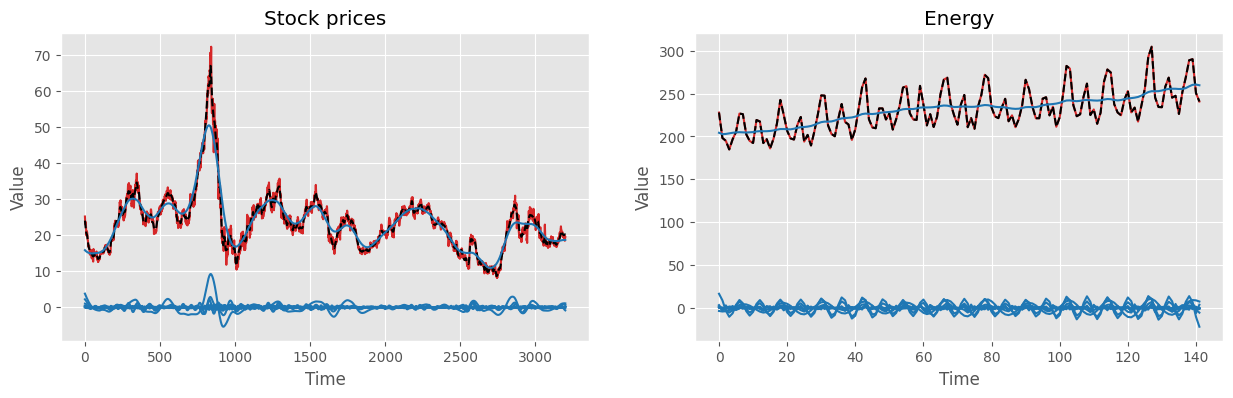

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(data_stock, color='tab:red')
axs[0].plot(np.sum(ts_opt_components_stock, axis=0), '--', color='black', ms=1)
axs[0].plot(ts_opt_components_stock.T, color='tab:blue', linewidth=1.5)

axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')
axs[0].set_title('Stock prices')


axs[1].plot(data_energy, color='tab:red')
axs[1].plot(np.sum(ts_opt_components_energy, axis=0), '--', color='black', ms=1)
axs[1].plot(ts_opt_components_energy.T, color='tab:blue', linewidth=1.5)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Value')
axs[1].set_title('Energy')

plt.show()

Тоже самое для акции, но с другой библиотекой и собственным разбиением на группы компонент.

In [16]:
from pyts.decomposition import SingularSpectrumAnalysis

In [17]:
window_size = 300
groups = [np.arange(i, i + 10) for i in range(0, 90, 5)]

ssa = SingularSpectrumAnalysis(window_size=200, groups=groups)
X_ssa = ssa.fit_transform(data_stock.reshape(1, -1))

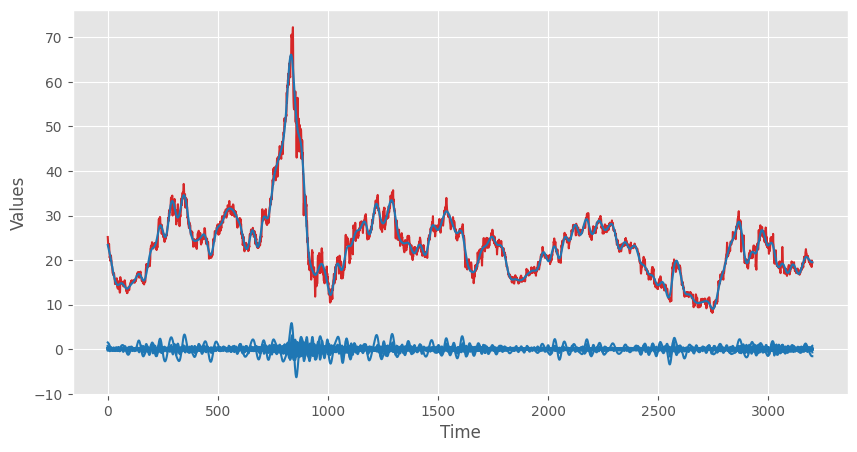

In [18]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data_stock, color='tab:red')
# plt.plot(np.sum(X_ssa[0], axis=0), '--', color='black', ms=1)

plt.plot(X_ssa[0].T, color='tab:blue', linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Values')

plt.show()

# 3.

Для прогнозирования воспользуемся библиотекой fbprophet.

In [61]:
from prophet import Prophet

In [123]:
pred_array = []

for comp in ts_opt_components_stock:
    fm = Prophet()
    fm.fit(pd.DataFrame(np.array([pd.date_range('2014-03-29', '2023-01-01'), comp]).T, columns=['ds', 'y']))
    pred_array.append(fm.predict(fm.make_future_dataframe(periods=200))['yhat'][-200:])

17:57:33 - cmdstanpy - INFO - Chain [1] start processing
17:57:35 - cmdstanpy - INFO - Chain [1] done processing
17:57:36 - cmdstanpy - INFO - Chain [1] start processing
17:57:36 - cmdstanpy - INFO - Chain [1] done processing
17:57:36 - cmdstanpy - INFO - Chain [1] start processing
17:57:36 - cmdstanpy - INFO - Chain [1] done processing
17:57:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:57:37 - cmdstanpy - INFO - Chain [1] start processing
17:57:46 - cmdstanpy - INFO - Chain [1] done processing
17:57:47 - cmdstanpy - INFO - Chain [1] start processing
17:57:47 - cmdstanpy - INFO - Chain [1] done processing
17:57:47 - cmdstanpy - INFO - Chain [1] start processing
17:57:48 - cmdstanpy - INFO - Chain [1] done processing
17:57:48 - cmdstanpy - INFO - Chain [1] start processing
17:57:48 - cmdstanpy - INFO - Chain [1] done processing
17:57:49 - cmdstanpy - INFO - Chain [1] start process

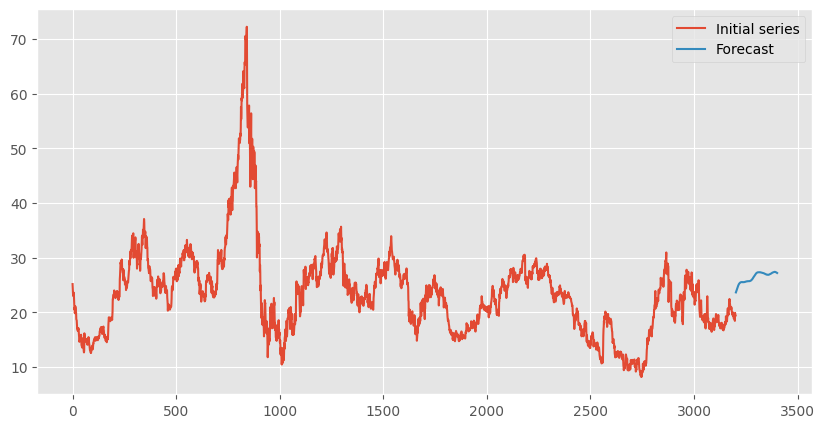

In [124]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data_stock, label='Initial series')
plt.plot(np.arange(200)+len(data_stock)+1, np.sum(pred_array, axis=0), label='Forecast')

plt.legend()
plt.show()

In [125]:
pred_array = []

for comp in ts_opt_components_energy:
    fm = Prophet()
    fm.fit(pd.DataFrame(np.array([pd.date_range('2014-01-01', '2014-05-22'), comp]).T, columns=['ds', 'y']))
    pred_array.append(fm.predict(fm.make_future_dataframe(periods=50))['yhat'][-50:])

17:58:40 - cmdstanpy - INFO - Chain [1] start processing


17:58:40 - cmdstanpy - INFO - Chain [1] done processing
17:58:40 - cmdstanpy - INFO - Chain [1] start processing
17:58:40 - cmdstanpy - INFO - Chain [1] done processing
17:58:40 - cmdstanpy - INFO - Chain [1] start processing
17:58:40 - cmdstanpy - INFO - Chain [1] done processing
17:58:40 - cmdstanpy - INFO - Chain [1] start processing
17:58:40 - cmdstanpy - INFO - Chain [1] done processing
17:58:40 - cmdstanpy - INFO - Chain [1] start processing
17:58:40 - cmdstanpy - INFO - Chain [1] done processing
17:58:41 - cmdstanpy - INFO - Chain [1] start processing
17:58:41 - cmdstanpy - INFO - Chain [1] done processing
17:58:41 - cmdstanpy - INFO - Chain [1] start processing
17:58:41 - cmdstanpy - INFO - Chain [1] done processing
17:58:41 - cmdstanpy - INFO - Chain [1] start processing
17:58:41 - cmdstanpy - INFO - Chain [1] done processing
17:58:41 - cmdstanpy - INFO - Chain [1] start processing
17:58:41 - cmdstanpy - INFO - Chain [1] done processing
17:58:41 - cmdstanpy - INFO - Chain [1] 

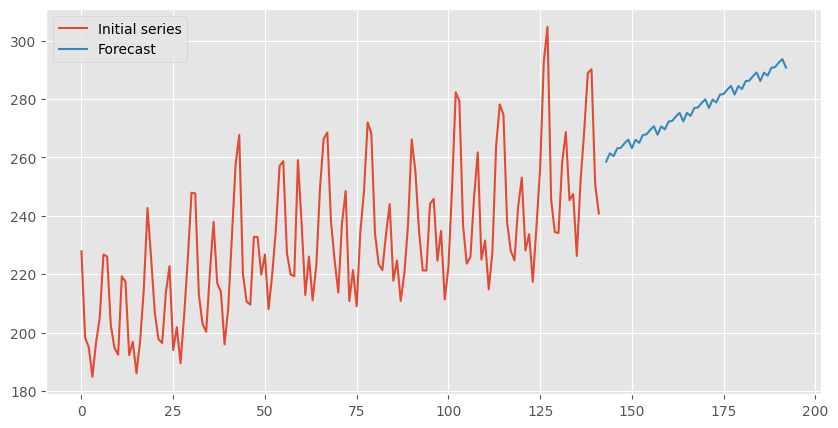

In [126]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data_energy, label='Initial series')
plt.plot(np.arange(50)+len(data_energy)+1, np.sum(pred_array, axis=0), label='Forecast')

plt.legend()
plt.show()

# 4.

In [329]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Красная область соответствует доверительному интервалу с уровнем доверия 0.05, значения лага которые попали внутрь нее, это тот шаг значений ряда которые не имеют значительной корреляции с предыдущими значениями. Шаг определается параметром задержки (lag). Для акции мы наблюдаем уменьшение корреляции с увелечением лага, это говорит о том, что значения ряда начинают меньше зависить друг от друга при удалении, что характерно для случайных процессов, особенно марковских, которым и являются котировки.

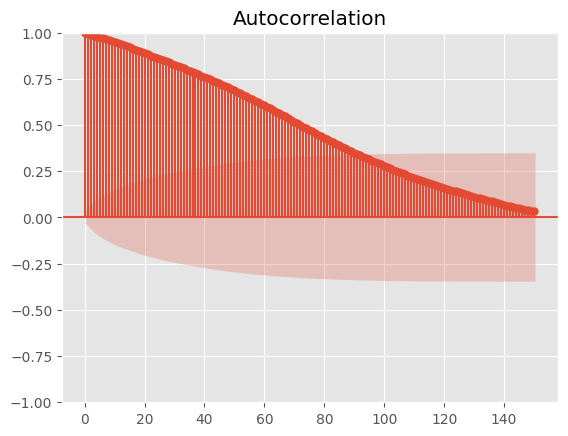

In [325]:
plot_acf(data_stock, lags=150)
plt.show()

Здесь мы наблюдаем сильную зависимость от предыдущих значений ряда, что может быть полезным для прогнозирования ряда. Наблюдается зависимость каждые 7 дней с затуханием.

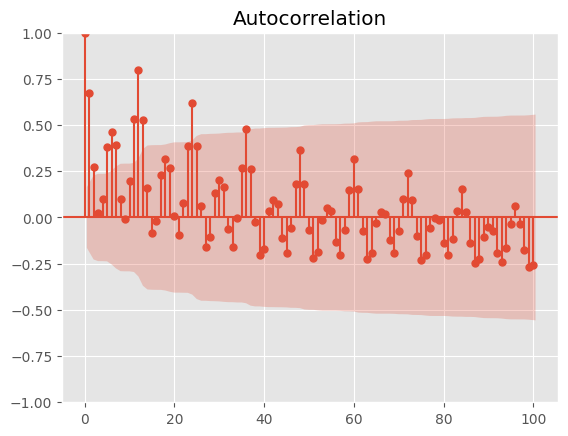

In [328]:
plot_acf(data_energy, lags=100)
plt.show()